In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import open3d as o3d

import numpy as np
from numpy import pi, sin, cos
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
import meshio
from pathlib import Path

/home/robert/.pyenv/versions/3.9.7/envs/venv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/robert/.pyenv/versions/3.9.7/envs/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Helper functions and model classes

In [2]:
# Sample a batch from the swiss roll
def sample_batch(size, noise=0.5):
    x, _ = make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-1, end=1e-1):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


def extract(input, t, shape):
    out = torch.gather(input, dim=0, index=t.to(input.device))  # get value at specified t
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(70, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 70)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)


def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x.shape)) / extract(one_minus_alphas_bar_sqrt, t, x.shape))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x.shape).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x.shape).sqrt()
    sample = mean + sigma_t * z
    return (sample)

def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0.shape)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0.shape)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()


class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

## Load dataset

In [3]:
data = np.load("bounding_boxes.npy")
data = data.reshape(-1, 70)
dataset = torch.Tensor(data).float()
data.shape

(3372, 70)

## Generate beta schedule

In [4]:
n_steps = 100  # number of steps
num_steps = n_steps
# betas = make_beta_schedule(schedule='linear', n_timesteps=num_steps, start=1e-3, end=1e-3)
# betas = make_beta_schedule(schedule='linear', n_timesteps=num_steps, start=1e-3, end=1e-3)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)

# betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, dim=0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar = alphas_prod
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

## Define model

In [5]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 16

## Train...

In [ ]:
batch_losses = []

n_steps_training = 5_000
pbar = tqdm(range(n_steps_training))
for t in pbar:
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    losses = []
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i + batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
        losses.append(loss.detach().item())
    batch_loss = np.array(losses).mean()
    pbar.set_postfix({'batch_loss': batch_loss})
    batch_losses.append(batch_loss)

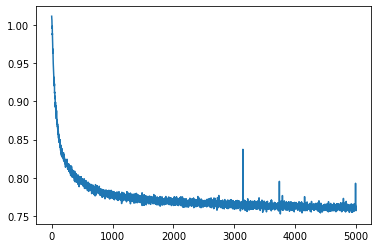

In [17]:
plt.plot(batch_losses)

In [18]:
torch.save(model.state_dict(), "model.pt")

## ... or load existing model

In [26]:
model.load_state_dict(torch.load("model.pt"))
model.eval()

ConditionalModel(
  (lin1): ConditionalLinear(
    (lin): Linear(in_features=70, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin2): ConditionalLinear(
    (lin): Linear(in_features=128, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin3): ConditionalLinear(
    (lin): Linear(in_features=128, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin4): Linear(in_features=128, out_features=70, bias=True)
)

## Plot results

### Visualize samples

In [20]:
# adapted from https://nbviewer.org/github/empet/Hollow-mask-illusion/blob/main/Hollow-Mask-illusion-Animation.ipynb
def scene_to_png(scene, png_filename):

    mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
    # objs = sample[-1].reshape(10, 7).detach().numpy()
    objs = scene
    for idx in range(10):
        obj = objs[idx,:]
        width, depth, height = obj[[0, 1, 2]]
        # scale.
        obb = o3d.geometry.TriangleMesh.create_box(width=width, height=height, depth=depth)
        # center.
        obb = obb.translate(-np.array([width, height, depth])/2)
        # rotate around z-axis.
        rot_vec_norm = np.array([0., 0., 1.])
        angle = obj[6]
        rot_vec = angle * rot_vec_norm
        rot_mat = o3d.geometry.get_rotation_matrix_from_axis_angle(rot_vec)
        obb = obb.rotate(rot_mat)
        # translate
        obb = obb.translate(obj[[3,4,5]])
        mesh += obb
    o3d.io.write_triangle_mesh("sample.obj", mesh)
    
    msh = meshio.read("sample.obj") # https://raw.githubusercontent.com/empet/Datasets/master/Meshes/face-mesh.obj
    verts = msh.points
    I, J, K =  msh.cells_dict["triangle"].T
    x, y, z = verts.T

    fig = make_subplots(rows=1, cols=1, 
                       horizontal_spacing=0.015,
                       specs=[[{'type': 'scene'}]])

    colorscale = [[0, 'rgb(100,100,100)'], 
                  [1, 'rgb(250,250,250)']]
    fig.add_trace(go.Mesh3d(x=x, y=y, z=z, 
                              i=I, j=J, k=K, 
                              intensity=z, 
                              colorscale =colorscale,
                              showscale=False,
                              lighting=dict(ambient=0.1,
                                            diffuse=1,
                                            fresnel=3,  
                                            specular=0.5, 
                                            roughness=0.05),
                              lightposition=dict(x=100,
                                                 y=200,
                                                 z=1000)
                           ), 1, 1)
    axis_prop =dict(visible=False, autorange=False)

    plotly_scenes = dict(xaxis=dict(range=[-11.41, 11.41], **axis_prop),
                  yaxis=dict(range=[-11.41, 11.41], **axis_prop),
                  zaxis=dict(range=[-8.67, 10.37], **axis_prop),
                  camera_eye=dict(x=1.85, y=1.85, z=0.65),
                  aspectratio=dict(x=10, y=10, z=10),
                  )# annotations = bbox_annotations)

    fig.update_layout(title_text=f"Bounding boxes for scene 0", title_x=0.5, title_y=0.95,
                      font_size=12, font_color="white",
                      width=800, height=400, autosize=False, 
                      margin=dict(t=2, r=2, b=2, l=2),
                      paper_bgcolor='black',
                      scene=plotly_scenes)
    fig.write_image(png_filename)

In [23]:
idx = 2
sample = p_sample_loop(model, [1, 70])
sample = np.concatenate([s.detach().numpy() for s in sample])
sample = sample.reshape(-1, 10, 7)
sample[:, :, :3] = np.abs(sample[:, :, :3])
Path(f"scene_{idx}").mkdir(exist_ok=True)
for i in tqdm(range(1, 101)):
    scene = sample[i]
    scene_to_png(scene, f"scene_{idx}/scene_{str(i).zfill(3)}.png")

100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


In [24]:
!convert -delay 10 -loop 1 scene_2/*png scene_2.gif

Open scene_1.gif in a GIF player.